In [20]:
import random
import cv2
import numpy as np
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

class TrivialAugment(ImageOnlyTransform):
    """
    Albumentations-style TrivialAugment.
    - Samples exactly one op per call in get_params (deterministic under A.ReplayCompose or seeded).
    - Optional debug: force_op (str) and/or force_level (int in [0, num_magnitude_bins-1]).
    """
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        force_op: str | None = None,
        force_level: int | None = None,
        always_apply: bool = False,
        p: float = 1.0,
    ):
        super().__init__(always_apply, p)
        self.num_magnitude_bins = int(num_magnitude_bins)
        self.force_op = force_op
        self.force_level = force_level

        self._op_table = {
            "rotate": self._rotate,
            "shear_x": self._shear_x,
            "shear_y": self._shear_y,
            "translate_x": self._translate_x,
            "translate_y": self._translate_y,
            "solarize": self._solarize,
            "posterize": self._posterize,
            "autocontrast": self._autocontrast,
            "equalize": self._equalize,
            "invert": self._invert,
            "contrast": self._contrast,
            "brightness": self._brightness,
            "color": self._color,
            "sharpness": self._sharpness,
            "cutout": self._cutout,
        }
        self._op_names = list(self._op_table.keys())

    # ---- Albumentations plumbing ----
    def get_params(self):
        if self.force_op is not None:
            op_name = self.force_op
            assert op_name in self._op_table, f"Unknown op: {op_name}"
        else:
            op_name = random.choice(self._op_names)

        if self.force_level is not None:
            level = int(self.force_level)
        else:
            level = random.randint(0, self.num_magnitude_bins - 1)

        return {"op_name": op_name, "level": level}

    def apply(self, img, op_name=None, level=None, **kwargs):
        # safety
        if op_name is None or level is None:
            params = self.get_params()
            op_name, level = params["op_name"], params["level"]
        return self._op_table[op_name](img, level)

    # ---- helpers ----
    def _interp(self, level, lo, hi):
        # map integer bin -> continuous magnitude
        return float(np.interp(level, [0, self.num_magnitude_bins - 1], [lo, hi]))

    # ---- ops (OpenCV / NumPy) ----
    def _rotate(self, img, level):
        deg = self._interp(level, 0, 30)
        if random.random() > 0.5: deg = -deg
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w / 2, h / 2), deg, 1.0)
        return cv2.warpAffine(img, M, (w, h),
                              flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_REFLECT_101)

    def _shear_x(self, img, level):
        mag = self._interp(level, 0, 0.3) * (1 if random.random() > 0.5 else -1)
        h, w = img.shape[:2]
        M = np.array([[1, mag, 0], [0, 1, 0]], dtype=np.float32)
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    def _shear_y(self, img, level):
        mag = self._interp(level, 0, 0.3) * (1 if random.random() > 0.5 else -1)
        h, w = img.shape[:2]
        M = np.array([[1, 0, 0], [mag, 1, 0]], dtype=np.float32)
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    def _translate_x(self, img, level):
        shift = int(self._interp(level, 0, 10)) * (1 if random.random() > 0.5 else -1)
        h, w = img.shape[:2]
        M = np.float32([[1, 0, shift], [0, 1, 0]])
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    def _translate_y(self, img, level):
        shift = int(self._interp(level, 0, 10)) * (1 if random.random() > 0.5 else -1)
        h, w = img.shape[:2]
        M = np.float32([[1, 0, 0], [0, 1, shift]])
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    def _solarize(self, img, level):
        thresh = int(self._interp(level, 0, 256))
        return np.where(img < thresh, img, 255 - img).astype(np.uint8)

    def _posterize(self, img, level):
        bits = int(self._interp(level, 4, 8))
        bits = np.clip(bits, 1, 8)
        shift = 8 - bits
        return np.left_shift(np.right_shift(img, shift), shift).astype(np.uint8)

    def _autocontrast(self, img, level):
        imin, imax = int(img.min()), int(img.max())
        if imax <= imin: return img
        out = (img.astype(np.float32) - imin) * 255.0 / (imax - imin)
        return np.clip(out, 0, 255).astype(np.uint8)

    def _equalize(self, img, level):
        if img.ndim == 2 or img.shape[2] == 1:
            return cv2.equalizeHist(img)
        chans = cv2.split(img)
        eq = [cv2.equalizeHist(c) for c in chans]
        return cv2.merge(eq)

    def _invert(self, img, level):
        return (255 - img).astype(np.uint8)

    def _contrast(self, img, level):
        v = self._interp(level, 0.1, 1.9)
        mean = img.mean(axis=(0, 1), keepdims=True)
        out = (img.astype(np.float32) - mean) * v + mean
        return np.clip(out, 0, 255).astype(np.uint8)

    def _brightness(self, img, level):
        v = self._interp(level, 0.1, 1.9)
        out = img.astype(np.float32) * v
        return np.clip(out, 0, 255).astype(np.uint8)

    def _color(self, img, level):
        v = self._interp(level, 0.1, 1.9)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
        hsv[..., 1] = np.clip(hsv[..., 1] * v, 0, 255)
        return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

    def _sharpness(self, img, level):
        v = self._interp(level, 0.1, 1.9)
        blur = cv2.GaussianBlur(img, (3, 3), 0)
        out = img.astype(np.float32) * v + blur.astype(np.float32) * (1.0 - v)
        return np.clip(out, 0, 255).astype(np.uint8)

    def _cutout(self, img, level):
        frac = self._interp(level, 0.0, 0.2)
        h, w = img.shape[:2]
        size = int(frac * min(h, w))
        if size <= 0: return img
        x0 = np.random.randint(0, max(1, w - size + 1))
        y0 = np.random.randint(0, max(1, h - size + 1))
        out = img.copy()
        out[y0:y0 + size, x0:x0 + size] = 0
        return out


In [22]:
# Common, stable asset used in HF docs:
URL = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"

resp = requests.get(URL, timeout=20)
resp.raise_for_status()
data = np.frombuffer(resp.content, dtype=np.uint8)
bgr = cv2.imdecode(data, cv2.IMREAD_COLOR)
if bgr is None:
    raise RuntimeError("Failed to decode image; check URL or network.")
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

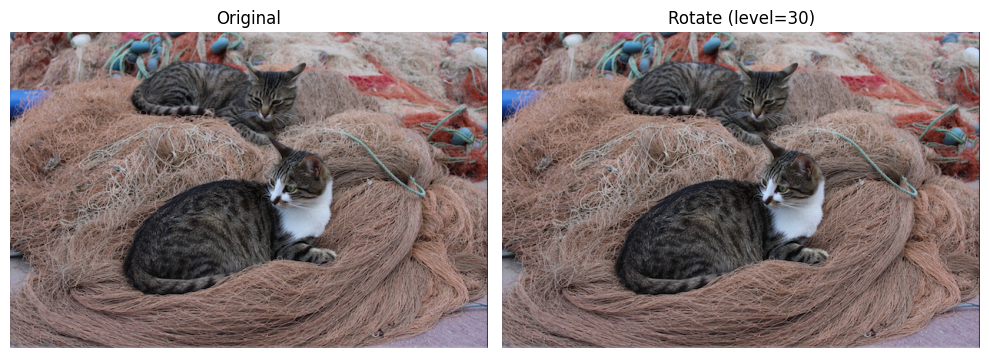

In [24]:
# force rotate with max level to guarantee a visible change
ta = A.Compose([
    TrivialAugment(num_magnitude_bins=31, force_op="rotate", force_level=30, p=1.0)
])

out = ta(image=rgb)["image"]   # rgb as loaded earlier
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb); plt.axis("off"); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(out); plt.axis("off"); plt.title("Rotate (level=30)")
plt.tight_layout(); plt.show()
